## Sentiment Analysis of Amazon reviews on Mobiles

In [199]:
#Importing important libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split

In [200]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MANISH\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [201]:
pip install wordcloud

In [202]:
from nltk import FreqDist
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [203]:
df=pd.read_csv('amazon_products.csv')
df.head()

,Mobile Model,Price,Overall Ratings,Reviews Count,Review Title,Reviewer,Reviewer Rating,Reviewe Comment
0,"Redmi Note 9 (Pebble Grey, 4GB RAM 64GB Storag...","₹ 10,999.00",4.2 out of 5 stars,"9,966",Dont buy.. after 10 to.15 mins gaming phone la...,Arpit,1.0 out of 5 stars,\n Dont buy.. after 10 to.15 mins gaming phon...
1,"Redmi Note 9 (Pebble Grey, 4GB RAM 64GB Storag...","₹ 10,999.00",4.2 out of 5 stars,"9,966",Overall a good phone 👌,Ujjwal,5.0 out of 5 stars,\n Good phoneDecent look and looks stylishCam...
2,"Redmi Note 9 (Pebble Grey, 4GB RAM 64GB Storag...","₹ 10,999.00",4.2 out of 5 stars,"9,966",Not good,Sam singh,2.0 out of 5 stars,\n Not good phone stopped working after some ...
3,"Redmi Note 9 (Pebble Grey, 4GB RAM 64GB Storag...","₹ 10,999.00",4.2 out of 5 stars,"9,966",Just Read before buying. My opinion,PRABAHARAN,3.0 out of 5 stars,\n Here my product review after usage of 2 we...
4,"Redmi Note 9 (Pebble Grey, 4GB RAM 64GB Storag...","₹ 10,999.00",4.2 out of 5 stars,"9,966",Worst,Malik,2.0 out of 5 stars,"\n Worst product, not as expected its not eve..."


Since we know the ratings are out of 5, we can keep only the rating and remove the extra part from it. From the customers_rated column, remove the comma. From the price column, remove the rupees symbol, comma, and split it by dot. Finally, convert all the three columns into integer or float.

In [204]:
#Extracting only rating out of given text
df['Overall Ratings'] = df['Overall Ratings'].apply(lambda x: x.split()[0])
df['Reviewer Rating'] = df['Reviewer Rating'].apply(lambda x: x.split()[0])

df['Overall Ratings'] = pd.to_numeric(df['Overall Ratings'])
df['Reviewer Rating'] = pd.to_numeric(df['Reviewer Rating'])
df['Reviewer Rating'] =df['Reviewer Rating'].astype('category')

In [205]:
#Replaceing currency sign,',' with space and converting into int
df["Price"] = df["Price"].str.replace('₹', '')
df["Price"] = df["Price"].str.replace(',', '')
df['Price'] = df['Price'].apply(lambda x: x.split('.')[0])
df['Price'] = df['Price'].astype(int)

In [206]:
#Seeing first five rows of the data frame
df.head()

,Mobile Model,Price,Overall Ratings,Reviews Count,Review Title,Reviewer,Reviewer Rating,Reviewe Comment
0,"Redmi Note 9 (Pebble Grey, 4GB RAM 64GB Storag...",10999,4.2,"9,966",Dont buy.. after 10 to.15 mins gaming phone la...,Arpit,1.0,\n Dont buy.. after 10 to.15 mins gaming phon...
1,"Redmi Note 9 (Pebble Grey, 4GB RAM 64GB Storag...",10999,4.2,"9,966",Overall a good phone 👌,Ujjwal,5.0,\n Good phoneDecent look and looks stylishCam...
2,"Redmi Note 9 (Pebble Grey, 4GB RAM 64GB Storag...",10999,4.2,"9,966",Not good,Sam singh,2.0,\n Not good phone stopped working after some ...
3,"Redmi Note 9 (Pebble Grey, 4GB RAM 64GB Storag...",10999,4.2,"9,966",Just Read before buying. My opinion,PRABAHARAN,3.0,\n Here my product review after usage of 2 we...
4,"Redmi Note 9 (Pebble Grey, 4GB RAM 64GB Storag...",10999,4.2,"9,966",Worst,Malik,2.0,"\n Worst product, not as expected its not eve..."


In [207]:
#Checking null values
df.isnull().sum()

Mobile Model       0
Price              0
Overall Ratings    0
Reviews Count      0
Review Title       0
Reviewer           0
Reviewer Rating    0
Reviewe Comment    0
dtype: int64

In [208]:
#Taking subset of the data frame which is relevent for sentiment analysis
df2=df[['Mobile Model','Reviewer Rating','Reviewe Comment']]
df2.head()

,Mobile Model,Reviewer Rating,Reviewe Comment
0,"Redmi Note 9 (Pebble Grey, 4GB RAM 64GB Storag...",1.0,\n Dont buy.. after 10 to.15 mins gaming phon...
1,"Redmi Note 9 (Pebble Grey, 4GB RAM 64GB Storag...",5.0,\n Good phoneDecent look and looks stylishCam...
2,"Redmi Note 9 (Pebble Grey, 4GB RAM 64GB Storag...",2.0,\n Not good phone stopped working after some ...
3,"Redmi Note 9 (Pebble Grey, 4GB RAM 64GB Storag...",3.0,\n Here my product review after usage of 2 we...
4,"Redmi Note 9 (Pebble Grey, 4GB RAM 64GB Storag...",2.0,"\n Worst product, not as expected its not eve..."


In most cases today, sentiment classifiers are used for binary classification (just positive or negative sentiment), and for good reason: fine-grained sentiment classification is a significantly more challenging task.

 The typical breakdown of fine-grained sentiment uses five discrete classes. 1-Strongly Negative,2-weakly Negative,3-Neutral,4-Weakly Positive and 5-Strongly positive
 

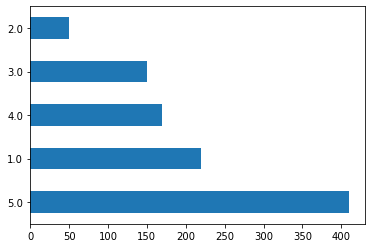

In [209]:
#Distribution of individual reviewer rating for all models of the mobile
df2['Reviewer Rating'].value_counts().plot(kind='barh')

In [210]:
#from above we can see that the whole dataset have review in which user has rated 5 maximum number of times

In [211]:
#let extract one particular model mobile data
df_5th_mobile=df2[400:500]
df_5th_mobile.shape

(100, 3)

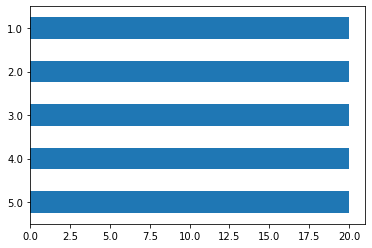

In [212]:
#Individual reviewer rating for the given mobile model
df_5th_mobile['Reviewer Rating'].value_counts().plot(kind='barh')

In [213]:
df_5th_mobile['Mobile Model'].nunique()

1

In [214]:
df_5th_mobile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 400 to 499
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Mobile Model     100 non-null    object  
 1   Reviewer Rating  100 non-null    category
 2   Reviewe Comment  100 non-null    object  
dtypes: category(1), object(2)
memory usage: 2.0+ KB


In [215]:
eda_df = df_5th_mobile.copy(deep=True)

In [216]:
### Input Text Cleanup ###

# Change all characters to lowercase
def change_to_lowercase(df):
    df['Reviewe Comment'] = df['Reviewe Comment'].apply(lambda x: x.lower())
    return (df)

# Drop HTML Tags
def drop_html_tags(df):
    df['Reviewe Comment'] = df['Reviewe Comment'].apply((lambda x: re.sub(r'<.*?>', ' ', x)))
    return (df)

# Drop HTTP Tags
def drop_http_tags(df):
    df['Reviewe Comment'] = df['Reviewe Comment'].apply((lambda x: re.sub("http\S+", ' ', x)))
    return (df)

# Drop Email Ids
def drop_email_ids(df):
    df['Reviewe Comment'] = df['Reviewe Comment'].apply((lambda x: re.sub("([\w\.-]+)@([\w\.-]+)",' ', x)))
    return (df)

# Drop Special Characters
def drop_special_chars(df):
    df['Reviewe Comment'] = df['Reviewe Comment'].apply((lambda x: re.sub(r'\r\n', ' ', x, re.I|re.A)))
    return (df)

# Drop Frequent Words
def drop_freq_words(df):
    freq_words = ['per', 'day', 'twice']
    df['Reviewe Comment'] = df['Reviewe Comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in freq_words]))
    return (df)

# Drop Symbols
def drop_symbols(df):
    df['Reviewe Comment'] = df['Reviewe Comment'].apply((lambda x: re.sub('[^a-zA-Z]', ' ', x)))
    return (df)

# Removing stopwords
def drop_stopwords(df):
    df['Reviewe Comment'] = df['Reviewe Comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords.words('english')]))
    return (df)

In [217]:
# Input Text Clean Up

# Change all characters to lowercase
eda_df = change_to_lowercase(eda_df)

# Drop Email Ids
eda_df = drop_email_ids(eda_df)

# Drop HTML Tags
eda_df = drop_html_tags(eda_df)

# Drop HTTP Tags
eda_df = drop_http_tags(eda_df)

# Drop Special Characters
eda_df = drop_special_chars(eda_df)

# Drop Symbols
eda_df = drop_symbols(eda_df)

# Drop Frequent Words
eda_df = drop_freq_words(eda_df)

# Remove stopwords
eda_df = drop_stopwords(eda_df)

In [218]:
eda_df.head()

,Mobile Model,Reviewer Rating,Reviewe Comment
400,"Redmi 9A (Sea Blue, 2Gb Ram, 32Gb Storage)",4.0,hello redmi phone bought fine know redmi alway...
401,"Redmi 9A (Sea Blue, 2Gb Ram, 32Gb Storage)",1.0,mp mp camera quality good lot pre installed ap...
402,"Redmi 9A (Sea Blue, 2Gb Ram, 32Gb Storage)",4.0,looking low budget phone good choice wanna and...
403,"Redmi 9A (Sea Blue, 2Gb Ram, 32Gb Storage)",3.0,made china product
404,"Redmi 9A (Sea Blue, 2Gb Ram, 32Gb Storage)",1.0,made china country origin mentioned descriptio...


In [219]:
eda_df['Reviewer Rating'].unique()

[4.0, 1.0, 3.0, 2.0, 5.0]
Categories (5, float64): [4.0, 1.0, 3.0, 2.0, 5.0]

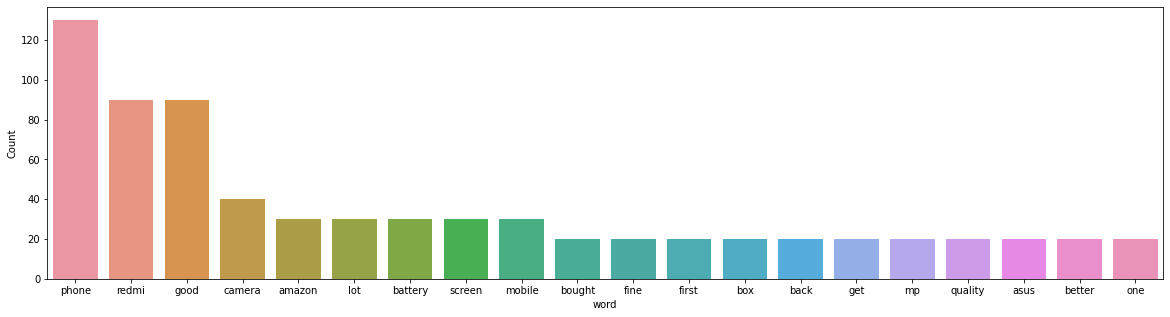

In [220]:
## Frequent word count
all_words = ' '.join([text for text in eda_df['Reviewe Comment']])
all_words = all_words.split()
fdist = FreqDist(all_words)
words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
  
# selecting top 20 most frequent words
d = words_df.nlargest(columns="count", n=20) 
plt.figure(figsize=(20,5))
ax = sns.barplot(data=d, x="word", y ="count")
ax.set(ylabel='Count')    
plt.show()

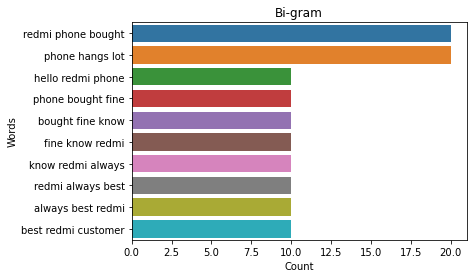

In [221]:
# Get top n-gram

vec = CountVectorizer(ngram_range=(3,3)).fit(eda_df['Reviewe Comment'])
bag_of_words = vec.transform(eda_df['Reviewe Comment'])
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0,idx]) 
                for word, idx in vec.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
x,y = map(list, zip(*words_freq[:10]))
sns.barplot(x=y, y=x)
plt.xlabel('Count') 
plt.ylabel('Words')
plt.title('Bi-gram')
plt.show() 

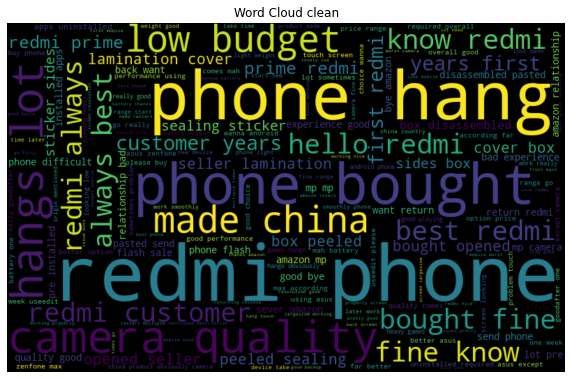

In [222]:
#Plotting the word cloud
all_words = ' '.join([text for text in eda_df['Reviewe Comment']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud clean')
plt.show()

In [223]:
#Splitting the data into train and test

df_train, df_test = train_test_split(eda_df, test_size=0.30, random_state=42, stratify=eda_df['Reviewer Rating'])

# Splitting Data into Input Variables and Output Variables
X_train = df_train['Reviewe Comment']
Y_train = df_train['Reviewer Rating']

X_test = df_test['Reviewe Comment']
Y_test = df_test['Reviewer Rating']

print("Training Data   : %s , %s" % (X_train.shape, Y_train.shape))
print("Testing Data    : %s , %s" % (X_test.shape, Y_test.shape))

Training Data   : (70,) , (70,)
Testing Data    : (30,) , (30,)


In [224]:
# TF-IDF Vectorization

vectorizer = TfidfVectorizer(sublinear_tf=True, ngram_range=(1, 3))
vectorizer.fit(X_train)
    
X_train_enc = vectorizer.transform(X_train)
X_test_enc = vectorizer.transform(X_test)

In [225]:
# Modelling
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, average_precision_score, recall_score, accuracy_score

#creating object of the model
model=LinearSVC(random_state=42)

#Fitting the model on train data
model.fit(X_train_enc, Y_train)

LinearSVC(random_state=42)

In [226]:
#Predicting the model on test set
Y_pred = model.predict(X_test_enc)
Y_pred

array([3., 3., 4., 3., 2., 5., 1., 1., 3., 5., 1., 3., 4., 2., 5., 4., 1.,
       2., 3., 4., 1., 2., 4., 2., 4., 5., 2., 5., 5., 1.])

In [227]:
#Calculating important metrics
acc = accuracy_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred, average='macro')
recall = recall_score(Y_test, Y_pred, average='macro')

In [228]:
model_results =pd.DataFrame([['Linear SVC', "TF-IDF", acc, f1, recall]], 
                                                        columns=['Model', 'Encoding', 'Accuracy', 'F1 Score', 'Recall Score'])
model_results

,Model,Encoding,Accuracy,F1 Score,Recall Score
0,Linear SVC,TF-IDF,1.0,1.0,1.0


In [229]:
#importing confusion matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(Y_test, Y_pred)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[6 0 0 0 0]
 [0 6 0 0 0]
 [0 0 6 0 0]
 [0 0 0 6 0]
 [0 0 0 0 6]]


In [230]:
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(Y_test, Y_pred, target_names=['1', '2', '3','4','5']))


Classification Report

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         6

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

